In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

def standarize(data, train_mean, std):
    return (data - train_mean) / std

In [141]:
class GRU:
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension

        self.wz = np.random.randn(hidden_dimension, input_dimension) * 0.01
        self.uz = np.random.randn(hidden_dimension, hidden_dimension) * 0.01
        self.bz = np.zeros((hidden_dimension, 1))

        self.wr = np.random.randn(hidden_dimension, input_dimension) * 0.01
        self.ur = np.random.randn(hidden_dimension, hidden_dimension) * 0.01
        self.br = np.zeros((hidden_dimension, 1))

        self.wh = np.random.randn(hidden_dimension, input_dimension) * 0.01
        self.uh = np.random.randn(hidden_dimension, hidden_dimension) * 0.01
        self.bh = np.zeros((hidden_dimension, 1))

        self.wp = np.random.randn(output_dimension, hidden_dimension) * 0.01
        self.bp = np.zeros((output_dimension, 1))

    def step(self, xt, h_prev):
        zt = sigmoid(self.wz @ xt + self.uz @ h_prev + self.bz)
        rt = sigmoid(self.wr @ xt + self.ur @ h_prev + self.br)

        h_tilde = np.tanh(self.wh @ xt + self.uh @ (rt * h_prev) + self.bh)
        ht = (1 - zt) * h_prev + zt * h_tilde
        
        return zt, rt, ht, h_tilde
    
    def forward(self, x):
        self.x = x
        self.T = x.shape[0]
        h_prev = np.zeros((self.hidden_dimension, 1))
        
        y_pred = []
        cache = []

        for t in range(self.T):
            xt = x[t].reshape(-1, 1)
            zt, rt, ht, h_tilde = self.step(xt, h_prev)
            h_prev = ht
            yt = self.wp @ ht + self.bp
            
            y_pred.append(yt)
            cache.append((xt, zt, rt, ht, h_tilde))

        return np.hstack(y_pred), cache
    
    def backward(self, y_true, y_pred, cache, learning_rate, clip_value):
        dwz, duz, dbz = np.zeros_like(self.wz), np.zeros_like(self.uz), np.zeros_like(self.bz)
        dwr, dur, dbr = np.zeros_like(self.wr), np.zeros_like(self.ur), np.zeros_like(self.br)
        dwh, duh, dbh = np.zeros_like(self.wh), np.zeros_like(self.uh), np.zeros_like(self.bh)
        dwp, dbp = np.zeros_like(self.wp), np.zeros_like(self.bp)

        dh_next = np.zeros((self.hidden_dimension, 1))
        dy = mse_derivative(y_true, y_pred)

        for t in reversed(range(self.T)):
            xt, zt, rt, ht, h_tilde = cache[t]

            dyt = dy[:, t].reshape(-1, 1)
            dwp += dyt @ ht.T
            dbp += dyt

            dht = self.wp.T @ dyt + dh_next
            dzt = dht * (h_tilde - ht) * zt * (1 - zt)
            dh_tilde = dht * zt * (1 - h_tilde ** 2)
            drt = (self.uh.T @ (dh_tilde * ht)) * rt * (1 - rt)

            dwz += dzt @ xt.T
            duz += dzt @ ht.T
            dbz += dzt

            dwr += drt @ xt.T
            dur += drt @ ht.T
            dbr += drt

            dwh += dh_tilde @ xt.T
            duh += dh_tilde @ (rt * ht).T
            dbh += dh_tilde

            dh_next = (self.uz.T @ dzt) + (self.ur.T @ drt) + ((self.uh.T @ dh_tilde) * rt) + (dht * (1 - zt))

        for grad in [dwz, duz, dbz, dwr, dur, dbr, dwh, duh, dbh, dwp, dbp]:
            np.clip(grad, -clip_value, clip_value, out=grad)

        self.wz -= learning_rate * dwz
        self.uz -= learning_rate * duz
        self.bz -= learning_rate * dbz

        self.wr -= learning_rate * dwr
        self.ur -= learning_rate * dur
        self.br -= learning_rate * dbr

        self.wh -= learning_rate * dwh
        self.uh -= learning_rate * duh
        self.bh -= learning_rate * dbh

        self.wp -= learning_rate * dwp
        self.bp -= learning_rate * dbp

    def train(self, x, y, epochs, learning_rate, clip_value):
        loss_list = []
        for epoch in range(epochs):
            epoch_loss = 0
            y_pred, cache = self.forward(x)
            loss = mse(y, y_pred)
            epoch_loss += loss
            self.backward(y, y_pred, cache, learning_rate, clip_value)
            loss_list.append(epoch_loss / x.shape[0])
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss}")
        return loss_list



In [142]:
file_path = '../../Datasets/조업편차분석.csv'
data = pd.read_csv(file_path)

data['Origin'] = data.index
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(len(shuffled_data) * 0.8)
train_data, test_data = shuffled_data.iloc[:train_size], shuffled_data.iloc[train_size:]

x_train, y_train = train_data.drop(columns=['No.', 'A1', 'Origin'], axis=1), train_data['A1']

x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
y_train_mean = np.mean(y_train, axis=0)
y_train_std = np.std(y_train, axis=0)

x_train = standarize(x_train, x_train_mean, x_train_std).to_numpy()
y_train = standarize(y_train, y_train_mean, y_train_std).to_numpy().reshape(1, -1)

test_data_sorted = test_data.sort_values(by='Origin').reset_index(drop=True)
x_test_sorted, y_test_sorted = test_data_sorted.drop(columns=['No.', 'A1', 'Origin'], axis=1), test_data_sorted['A1']

x_test_sorted = standarize(x_test_sorted, x_train_mean, x_train_std).to_numpy()
y_test_sorted = standarize(y_test_sorted, y_train_mean, y_train_std).to_numpy().reshape(1, -1)

In [143]:
model = GRU(53, 64, 1)
loss_list = model.train(x_train, y_train, 1000, 0.01, 1.0)

Epoch 100, Loss: 0.5005973596939672
Epoch 200, Loss: 0.2872545459126951
Epoch 300, Loss: 0.24545639297162464
Epoch 400, Loss: 0.21713620543015658
Epoch 500, Loss: 0.19334541849730846
Epoch 600, Loss: 0.1714423753086733
Epoch 700, Loss: 0.15016841085847726
Epoch 800, Loss: 0.12908668387077457
Epoch 900, Loss: 0.10869183612358008
Epoch 1000, Loss: 0.09031952295416092


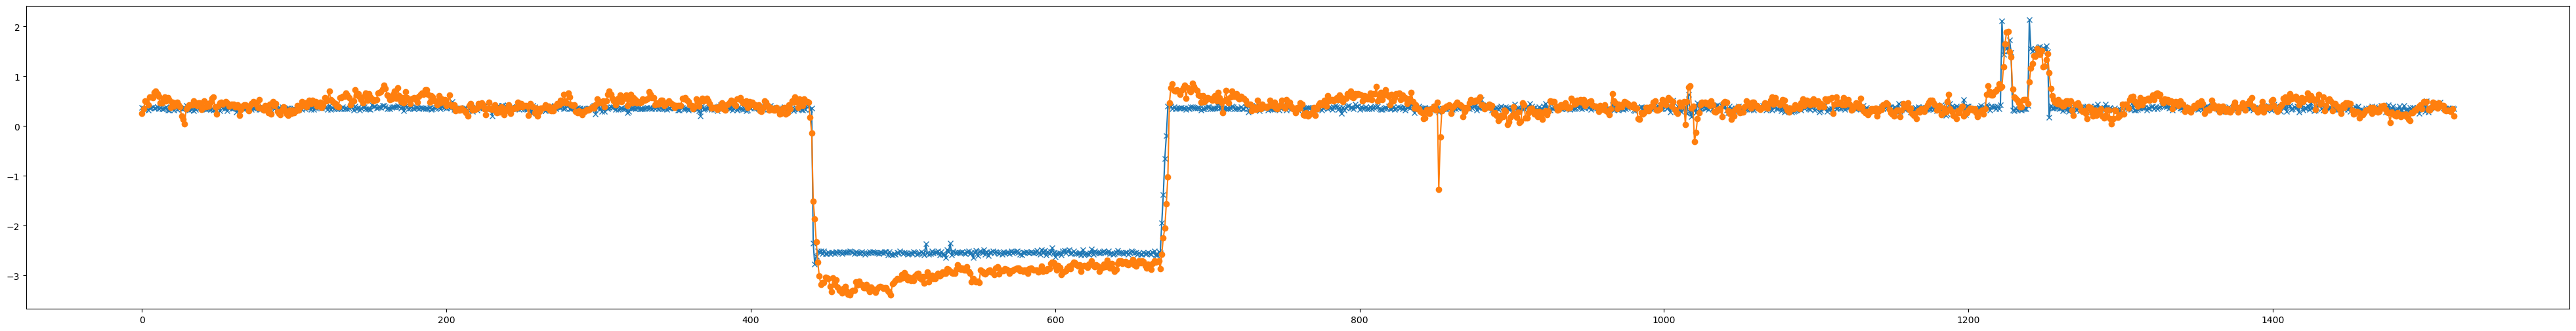

In [145]:
y_pred, _ = model.forward(x_test_sorted)

plt.figure(figsize=(50, 6))
plt.plot(y_test_sorted.reshape(-1, 1), marker="x")
plt.plot(y_pred.reshape(-1, 1), marker="o")
plt.show()

In [146]:
def calculate_metrics(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return r2, rmse, mae, mape

calculate_metrics(y_test_sorted, y_pred)

(0.9458987176775908,
 0.24593803955245272,
 0.17248730368960255,
 32.173517285055716)